# Ames Housing: A Statistical Deep Dive into Home Value

## 1. Project Goal

The primary objective of this project is to conduct a comprehensive Exploratory Data Analysis (EDA) on the Ames Housing dataset. This analysis is framed as the foundational work required before building a predictive regression model.

Our goal is to uncover the key factors that drive house prices (`SalePrice`). We will focus on:
*   Understanding the distribution of our target variable, `SalePrice`, and the importance of transformations.
*   Identifying the most influential numerical and categorical features.
*   Investigating the assumptions of linear regression, such as linearity and homoscedasticity, through visualization.
*   Building a clear, data-driven "story" of what makes a house valuable in Ames, Iowa.

## 2. The Dataset

This analysis uses the Ames Housing dataset, compiled by Professor Dean De Cock of Truman State University. It is a famously rich and complex dataset containing 82 columns that describe almost every conceivable aspect of residential homes.

*   **Source:** The data was obtained from [Kaggle](https://www.kaggle.com/datasets/prevek18/ames-housing-dataset) and is accompanied by a detailed data dictionary.
*   **Data Dictionary:** A full description of all features is available in the `data_description.txt` file located in the `data/` folder.

### Key Variable Groups (Abridged Data Dictionary)

*   **Identifiers:** `PID` (Parcel Identification Number)
*   **Primary Target:** `SalePrice` (The property's sale price in dollars).
*   **Location Features:** `Neighborhood`, `MS Zoning`.
*   **Lot Features:** `Lot Area`, `Lot Frontage`, `Lot Shape`.
*   **Quality & Condition:** `Overall Qual`, `Overall Cond`, `Exter Qual`, `Kitchen Qual`, etc. (Many of these are ordinal).
*   **Size & Space:** `Gr Liv Area` (Above Grade Living Area), `Total Bsmt SF` (Total Basement Square Feet), `Garage Area`.
*   **Structural/Temporal:** `Year Built`, `Year Remod/Add`, `House Style`, `Foundation`.
*   **Amenities:** `Garage Cars`, `Fireplaces`, `Pool Area`.

This initial overview will guide our exploration of this feature-rich dataset.

In [1]:
# --- 1. Setup & Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from google.colab import drive

# Mount Google Drive
# drive.mount("/content/drive")

# Add utility file to python path
sys.path.append('../utils')

# Import custom reporting function
import eda_utils

In [2]:
# --- 2. LOAD DATA ---
# Define the file path
file_path = './data/AmesHousePrice.csv'

# Load the data
df = pd.read_csv(file_path)

In [4]:
# --- 3. INITIAL EXPLORATION ---
# Now that 'df' is loaded, let's run our initial report.
print("\n--- Generating Initial Report ---")
eda_utils.initial_report(df)


--- Generating Initial Report ---
--- Initial Data Report ---

--- Shape ---
Rows: 2930, Columns: 82

--- Data Types & Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1 

#### Initial Obsevations

1. Missing Data (A LOT of it)
The Clue: The Missing Values (%) section is huge.
The Insight: This is the primary challeng. The data can't just be dropped or filled. We have to think about why the data is missing.
- High-Percentage Missing (Alley, Pool QC, Fence, Misc Feature): These are not missing at random. A NaN in Pool QC doesn't mean "we forgot to record the pool quality"; it means "there is no pool". The data dictionary will confirm this. For these, NaN is actually a category. We will need to replace NaN with a specific string like 'None'. Fireplace Qu is the same—no fireplace means no fireplace quality.
- Moderate-Percentage Missing (Lot Frontage): This is different. A house must have a lot frontage. This data is likely missing at random. We can't just fill it with 'None'. We'll need a smarter imputation strategy, perhaps filling it with the median frontage for that specific Neighborhood.
- Small-Percentage Missing (Basement & Garage Features): Looking at the Bsmt... and Garage... columns. They often have the same number of missing values. This tells a story: if a house has no basement, all basement-related features will be NaN. We will handle these together, likely replacing categorical NaNs with 'None' and numerical NaNs (like Garage Area) with 0.

2. Redundant and Unhelpful Columns
The Clue: Order and PID are unique for every row.
The Insight: These are just identifiers, like Row ID from the Superstore set. They provide no predictive value about the house itself. We should drop them.

3. Messy Column Names
The Clue: Column names have spaces and mixed cases (MS SubClass, Lot Area, SalePrice).
The Insight: We need to standardize these to snake_case for clean, professional code.

4. Wrong Data Types for Categorical Features
The Clue: Looking at MS SubClass. The data dictionary tells us this is a category (e.g., 20 means "1-STORY 1946 & NEWER ALL STYLES"). But df.info() shows it as an int64. The same is true for Mo Sold and Yr Sold.
The Insight: These are not true numerical values. You can't say Mo Sold of 12 (December) is twice as "good" as 6 (June). We must convert these numerical codes into object or category types so they are treated correctly in our analysis.

5. Ordinal Features Disguised as Strings
The Clue: Columns like Exter Qual, Bsmt Qual, Heating QC, Kitchen Qual. They have values like 'Ex' (Excellent), 'Gd' (Good), 'TA' (Typical/Average), 'Fa' (Fair), 'Po' (Poor).
The Insight: These are not just categories; they are ordinal. There is a clear, ranked order. Ex > Gd > TA. To use these powerful features effectively in modeling, we need to map these string values to a numerical scale (e.g., Ex=5, Gd=4, TA=3...). This is a key feature engineering step to be perfored.


## 2. Data Cleaning and Preparation

The initial report highlights the complexity of this dataset, revealing numerous missing values, inconsistent data types, and non-standard column names. This section will systematically clean and prepare the data to make it suitable for rigorous analysis. The plan is as follows:

1.  **Standardize Column Names:** Convert all columns to a consistent `snake_case` format.
2.  **Drop Identifier Columns:** Remove columns that serve only as unique IDs.
3.  **Correct Data Types:** Convert numerical codes that represent categories (like `MS SubClass`) into their proper format.
4.  **Handle Missing Values:** This will be a multi-step process, addressing different types of missingness with appropriate strategies.
5.  **Feature Engineering (Ordinal Mapping):** Convert ordinal categorical features (like quality ratings) into a numerical scale.

### 2.1 Standardize Column Names and Drop Identifiers

First, we will clean up the column names by converting them to lowercase `snake_case` for easier access in our code. At the same time, we will drop the `Order` and `PID` columns, as they are simply identifiers with no predictive value for house prices.

In [5]:
# --- Task 1: Standardize Column Names ---
# We use the same effective list comprehension as in our previous project.
clean_cols = [col.replace(' ', '_').replace('/', '_').lower() for col in df.columns]
df.columns = clean_cols

# --- Task 2: Drop Identifier Columns ---
# 'order' and 'pid' are not useful for predicting house value.
df.drop(columns=['order', 'pid'], inplace=True)


# --- Verification ---
print("--- Verifying Column Cleanup ---")
print(f"New shape of the DataFrame: {df.shape}")
print("\nFirst 10 cleaned column names:")
print(df.columns[:10])

--- Verifying Column Cleanup ---
New shape of the DataFrame: (2930, 80)

First 10 cleaned column names:
Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config'],
      dtype='object')


### 2.2 Correcting Data Types

Several columns are represented as numbers but are actually categorical in nature. For example, `ms_subclass` is a code for the type of dwelling, and `mo_sold` is the month of sale. We must convert these to `object` or `category` types so they are not misinterpreted as continuous numerical values in our analysis.

In [6]:
# --- Task 3: Convert numerical codes to categorical type ---
# These columns are codes, not numerical values. We'll convert them to strings.
cols_to_convert = [
    'ms_subclass', 'mo_sold', 'yr_sold'
]

for col in cols_to_convert:
    df[col] = df[col].astype(str)

# --- Verification ---
print("--- Verifying Data Types After Conversion ---")
# Let's check the dtypes of the columns we changed.
print(df[cols_to_convert + ['saleprice']].info())

--- Verifying Data Types After Conversion ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ms_subclass  2930 non-null   object
 1   mo_sold      2930 non-null   object
 2   yr_sold      2930 non-null   object
 3   saleprice    2930 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 91.7+ KB
None


### 2.3 Handling Missing Values

This dataset contains a significant number of missing values. Our strategy for handling them will depend on the *reason* for the missingness, as revealed by the data dictionary. We will address them in logical groups.

#### Group 1: Features Where 'NaN' Means 'None'

For many features, a missing value simply indicates the absence of that feature on the property. For example, a `NaN` in `pool_qc` means the house does not have a pool. For these columns, we will replace `NaN` with the string `'None'`. This correctly treats the absence of a feature as a distinct category.

In [7]:
# --- Identify the columns where NaN means 'None' ---
# These are typically categorical features related to amenities or house components.
cols_nan_is_none = [
    'alley', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1',
    'bsmtfin_type_2', 'fireplace_qu', 'garage_type', 'garage_finish',
    'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature'
]

# Loop through the columns and fill NaN with 'None'
for col in cols_nan_is_none:
    df[col] = df[col].fillna('None')


# --- Verification ---
print("--- Verifying 'None' Imputation ---")
# Let's check a few of these columns to see their new value counts.
print(df['pool_qc'].value_counts())
print("\n")
print(df['alley'].value_counts())

--- Verifying 'None' Imputation ---
pool_qc
None    2917
Ex         4
Gd         4
TA         3
Fa         2
Name: count, dtype: int64


alley
None    2732
Grvl     120
Pave      78
Name: count, dtype: int64


Similarly, for numerical columns associated with these non-existent features (e.g., garage area, basement square footage), the appropriate value for a missing entry is `0`.

In [8]:
# --- Identify numerical columns where NaN means zero ---
cols_nan_is_zero = [
    'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
    'bsmt_full_bath', 'bsmt_half_bath', 'garage_cars', 'garage_area'
]

# Loop through the columns and fill NaN with 0
for col in cols_nan_is_zero:
    df[col] = df[col].fillna(0)

# --- Verification ---
print("\n--- Verifying Zero Imputation ---")
print(f"Nulls in 'total_bsmt_sf' after imputation: {df['total_bsmt_sf'].isnull().sum()}")
print(f"Nulls in 'garage_area' after imputation: {df['garage_area'].isnull().sum()}")


--- Verifying Zero Imputation ---
Nulls in 'total_bsmt_sf' after imputation: 0
Nulls in 'garage_area' after imputation: 0


#### Group 2: Features Missing at Random - `lot_frontage`

The `lot_frontage` column has a significant amount of missing data (~17%). Unlike the previous features, a missing value here does not mean the absence of a lot frontage. This data is likely missing at random.

A naive approach would be to fill these with the overall median `lot_frontage` of the entire dataset. However, a more sophisticated and accurate strategy is to impute the value based on the **neighborhood**. We will assume that houses within the same neighborhood tend to have similar lot frontages.

Therefore, we will fill the missing `lot_frontage` values for each house with the **median `lot_frontage` of its respective neighborhood.**

In [9]:
# --- Task: Impute 'lot_frontage' ---

# We use the .transform() method here. It's a powerful tool in .groupby().
# For each row, it looks up the 'neighborhood', calculates the median 'lot_frontage'
# for that entire neighborhood group, and then "broadcasts" that median value
# back to the row.
# This single line calculates the appropriate median for every single row.
df['lot_frontage'] = df.groupby('neighborhood')['lot_frontage'].transform(
    lambda x: x.fillna(x.median())
)


# --- Verification ---
print("--- Verifying 'lot_frontage' Imputation ---")
print(f"Nulls in 'lot_frontage' after imputation: {df['lot_frontage'].isnull().sum()}")

--- Verifying 'lot_frontage' Imputation ---
Nulls in 'lot_frontage' after imputation: 3


/Users/julianlehane/Projects/Data_Analysis_Portfolio/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/julianlehane/Projects/Data_Analysis_Portfolio/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### Group 3: Handling Remaining Missing Values

After our targeted imputation, a few columns still have a small number of missing values. We will handle these last cases to complete our data cleaning.

*   **`lot_frontage`:** Our neighborhood-based imputation left 3 nulls, likely because some neighborhoods had no frontage data at all. We will fill these with the overall median `lot_frontage`.
*   **Masonry Veneer (`mas_vnr_type`, `mas_vnr_area`):** Similar to our first group, a missing value likely means the house has no masonry veneer. We will fill the type with `'None'` and the area with `0`.
*   **Garage Year Built (`garage_yr_blt`):** Since we already filled `garage_type` with `'None'`, we can assume these missing year values correspond to houses without a garage. We can fill these with `0` as a placeholder, as the year is irrelevant if there's no garage.
*   **`electrical`:** With only one missing value, filling it with the most common value (the mode) is a safe and reasonable approach.

In [10]:
# --- Handle the 3 remaining lot_frontage nulls with the global median ---
# Explicitly assign the result back to the slice selected by .loc
# This is the modern, warning-free way to do what inplace=True used to do.
df.loc[df['lot_frontage'].isnull(), 'lot_frontage'] = df['lot_frontage'].median()


# --- Handle Masonry Veneer ---
# Use .loc to target the nulls in 'mas_vnr_type' and set them to 'None'
df.loc[df['mas_vnr_type'].isnull(), 'mas_vnr_type'] = 'None'

# Use .loc to target the nulls in 'mas_vnr_area' and set them to 0
df.loc[df['mas_vnr_area'].isnull(), 'mas_vnr_area'] = 0


# --- Handle Garage Year Built ---
# Use .loc to target the nulls in 'garage_yr_blt' and set them to 0
df.loc[df['garage_yr_blt'].isnull(), 'garage_yr_blt'] = 0


# --- Handle Electrical with the mode ---
electrical_mode = df['electrical'].mode()[0]
# Use .loc to target the nulls in 'electrical' and set them to the mode
df.loc[df['electrical'].isnull(), 'electrical'] = electrical_mode


# --- Final, Final Verification ---
print("--- Final Check for Any Remaining Missing Values ---")
missing_count = df.isnull().sum().sum()
print(f"Total number of missing values in the entire DataFrame: {missing_count}")

if missing_count == 0:
    print("\nCongratulations! All missing values have been handled. (Warning-free method)")

--- Final Check for Any Remaining Missing Values ---
Total number of missing values in the entire DataFrame: 0

Congratulations! All missing values have been handled. (Warning-free method)


In [10]:
# --- Final Sanity Check After Refactoring ---

print("--- Data Shape ---")
print(df.shape) # Should be (2930, 80) after dropping 2 and not adding any

print("\n--- Missing Values ---")
print(f"Total Missing Values: {df.isnull().sum().sum()}") # Should be 0

print("\n--- Data Type Check (Spot Check) ---")
# Let's check a column from each of our imputation steps
print(f"Dtype of 'lot_frontage': {df['lot_frontage'].dtype}") # Should be float64
print(f"Dtype of 'mas_vnr_type': {df['mas_vnr_type'].dtype}") # Should be object
print(f"Dtype of 'electrical': {df['electrical'].dtype}")   # Should be object

print("\n--- Value Counts Check (Spot Check) ---")
# Check if our 'None' imputation worked as expected
print("Value counts for 'mas_vnr_type':")
print(df['mas_vnr_type'].value_counts().head())

--- Data Shape ---
(2930, 80)

--- Missing Values ---
Total Missing Values: 0

--- Data Type Check (Spot Check) ---
Dtype of 'lot_frontage': float64
Dtype of 'mas_vnr_type': object
Dtype of 'electrical': object

--- Value Counts Check (Spot Check) ---
Value counts for 'mas_vnr_type':
mas_vnr_type
None       1775
BrkFace     880
Stone       249
BrkCmn       25
CBlock        1
Name: count, dtype: int64


### 2.4 Feature Engineering: Mapping Ordinal Features

The final step in our data preparation is to handle the **ordinal categorical features**. These are columns where the string values have an inherent, logical order (e.g., 'Excellent' is better than 'Good'). Leaving them as strings loses this valuable information.

We will map these qualitative ranks to a numerical scale. This process, often called "label encoding," allows machine learning models to understand the relative quality of these features. For example, we will map:
*   `Ex` (Excellent) -> 5
*   `Gd` (Good) -> 4
*   `TA` (Typical/Average) -> 3
*   `Fa` (Fair) -> 2
*   `Po` (Poor) -> 1
*   `None` (No such feature) -> 0

This transformation turns subjective quality ratings into powerful numerical features.

In [11]:
# --- Create the mapping dictionary ---
# We define the order once and can reuse it.
quality_mapping = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'None': 0
}

# --- Identify all columns that use this quality scale ---
# It's good practice to list them explicitly.
ordinal_cols = [
    'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'heating_qc',
    'kitchen_qual', 'fireplace_qu', 'garage_qual', 'garage_cond', 'pool_qc'
]

# --- Apply the mapping to each column ---
for col in ordinal_cols:
    # We use .map() to replace each string with its corresponding number
    df[col] = df[col].map(quality_mapping)


# --- Verification ---
print("--- Verifying Ordinal Mapping ---")
print("First 5 rows of mapped quality columns:")
print(df[['exter_qual', 'bsmt_qual', 'kitchen_qual']].head())

print("\nData types of mapped columns:")
# They should now be integers or floats
print(df[ordinal_cols].info())

--- Verifying Ordinal Mapping ---
First 5 rows of mapped quality columns:
   exter_qual  bsmt_qual  kitchen_qual
0           3          3             3
1           3          3             3
2           3          3             4
3           4          3             5
4           3          4             3

Data types of mapped columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   exter_qual    2930 non-null   int64
 1   exter_cond    2930 non-null   int64
 2   bsmt_qual     2930 non-null   int64
 3   bsmt_cond     2930 non-null   int64
 4   heating_qc    2930 non-null   int64
 5   kitchen_qual  2930 non-null   int64
 6   fireplace_qu  2930 non-null   int64
 7   garage_qual   2930 non-null   int64
 8   garage_cond   2930 non-null   int64
 9   pool_qc       2930 non-null   int64
dtypes: int64(10)
memory usage: 229.0 KB
None


#### Preparation Complete!

With this final step, our data preparation phase is finished.

The DataFrame is now fully prepared for the exploratory data analysis.

Let's start with our first planned step: analyzing the target variable, saleprice.

## 3. Exploratory Data Analysis (EDA)

With our data fully cleaned and prepared, we can now begin the exploration phase. As planned, our EDA will be statistically oriented, focusing on understanding the data in the context of preparing for a regression model.

### 3.1 Analyzing the Target Variable: `saleprice`

The most important feature in our dataset is the target variable, `saleprice`. The assumptions of many regression models (particularly linear regression) are sensitive to the distribution of the target. We must start by understanding its characteristics.

**Question:** Is `saleprice` normally distributed?

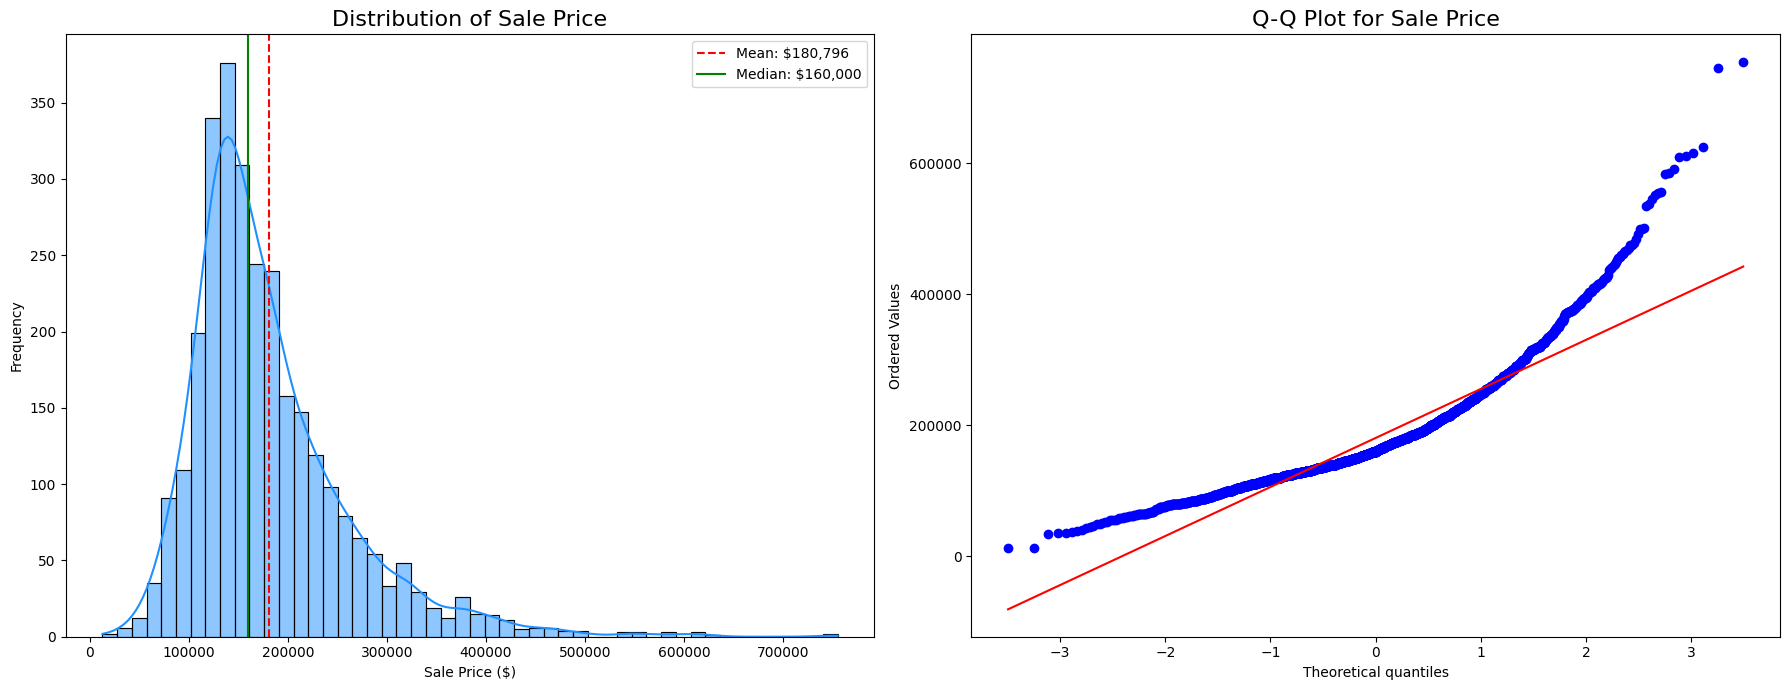

In [12]:
# Import the necessary statistical plotting library
import scipy.stats as stats

# --- Set up the figure for two subplots ---
# We'll have the histogram/KDE on the left and the Q-Q plot on the right.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# --- Plot 1: Histogram and KDE Plot ---
sns.histplot(df['saleprice'], kde=True, ax=axes[0], color='dodgerblue', bins=50)
axes[0].set_title('Distribution of Sale Price', fontsize=16)
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_ylabel('Frequency')

# Add lines for mean and median to highlight the skew
mean_price = df['saleprice'].mean()
median_price = df['saleprice'].median()
axes[0].axvline(mean_price, color='red', linestyle='--', label=f'Mean: ${mean_price:,.0f}')
axes[0].axvline(median_price, color='green', linestyle='-', label=f'Median: ${median_price:,.0f}')
axes[0].legend()


# --- Plot 2: Q-Q Plot ---
# stats.probplot generates the values for a probability plot
stats.probplot(df['saleprice'], plot=axes[1])
axes[1].set_title('Q-Q Plot for Sale Price', fontsize=16)


plt.tight_layout()
plt.show()

**Observations:**

1.  **Right Skewness:** The histogram clearly shows that the `saleprice` distribution is not normal. It is **positively (right) skewed**. The long tail extends to the right, indicating a small number of very expensive houses. This is confirmed by the fact that the **mean is greater than the median**.
2.  **Deviation from Normality:** The Q-Q plot confirms this finding. The data points form a curve that deviates significantly from the red diagonal line, especially at the higher quantiles (the right tail). A normally distributed variable would have its points lying almost perfectly on this line.

**Implication for Modeling:**
This severe right-skewness can be problematic for linear regression models, as it often leads to the violation of the assumption of normally distributed residuals (a pattern known as heteroscedasticity).

**Action:**
To address this, a common and highly effective technique is to apply a **logarithmic transformation** to the `saleprice`. This can help normalize the distribution, stabilize the variance, and improve the performance and reliability of linear models. Let's apply this transformation and see the result.

### 3.2 Applying a Log Transformation to `saleprice`

To correct the right-skewness of the `saleprice` distribution, we will apply a **logarithmic transformation**. Specifically, we'll use `np.log1p`, which calculates `log(1 + x)`. This is a good practice as it handles any potential zero values gracefully (though we don't have any in `saleprice`, it's a robust habit).

This transformation will compress the range of the variable, pulling the long tail inwards and making the distribution more symmetrical and closer to normal. We will create a new column, `log_saleprice`, to store the transformed values.

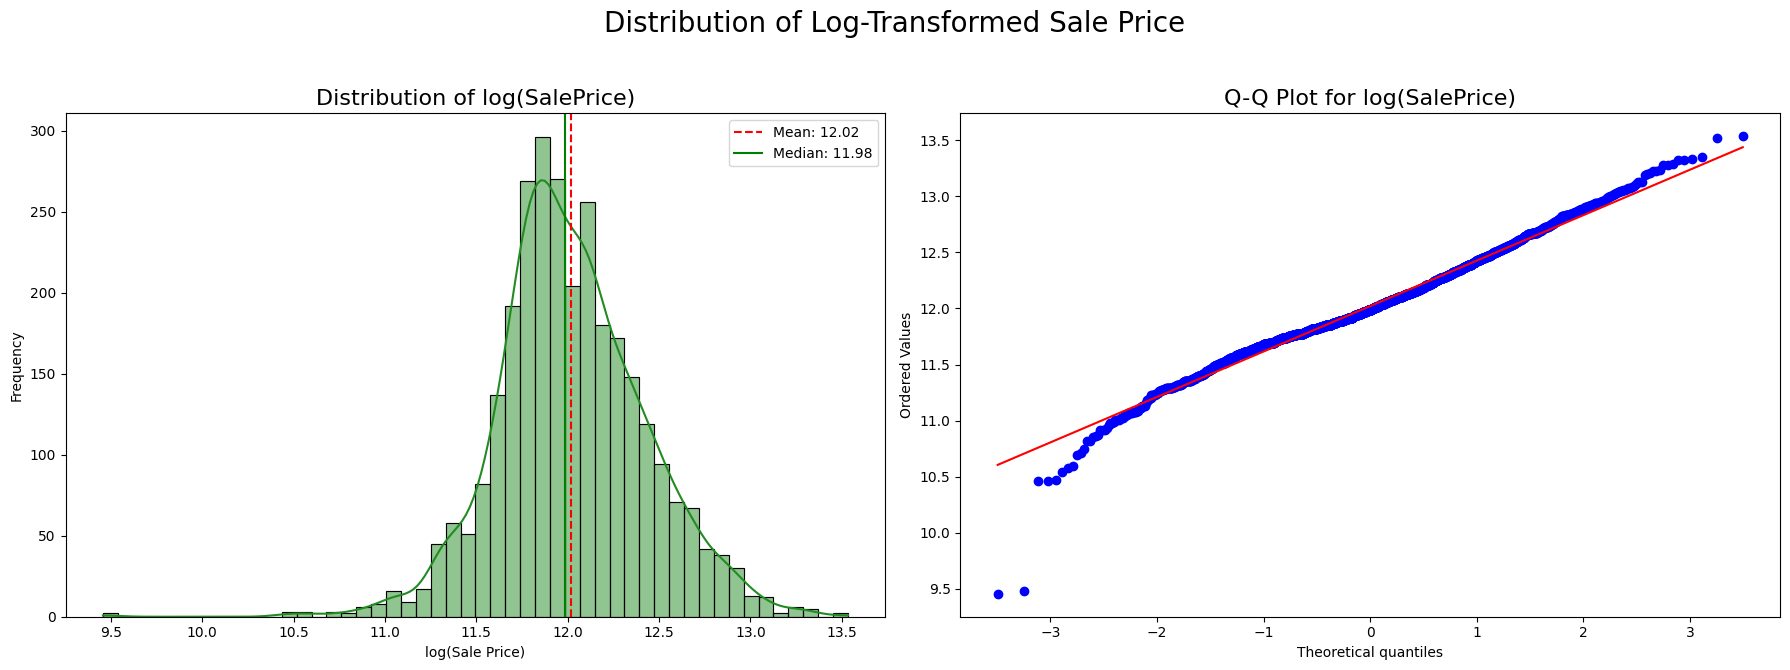

In [13]:
# --- Apply the log(1+x) transformation ---
# We create a new column to hold the transformed target variable.
df['log_saleprice'] = np.log1p(df['saleprice'])


# --- Set up the figure for the "After" plots ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
fig.suptitle('Distribution of Log-Transformed Sale Price', fontsize=20)


# --- Plot 1: Histogram and KDE Plot of the transformed data ---
sns.histplot(df['log_saleprice'], kde=True, ax=axes[0], color='forestgreen', bins=50)
axes[0].set_title('Distribution of log(SalePrice)', fontsize=16)
axes[0].set_xlabel('log(Sale Price)')
axes[0].set_ylabel('Frequency')

# Add lines for mean and median to show the new symmetry
mean_log_price = df['log_saleprice'].mean()
median_log_price = df['log_saleprice'].median()
axes[0].axvline(mean_log_price, color='red', linestyle='--', label=f'Mean: {mean_log_price:.2f}')
axes[0].axvline(median_log_price, color='green', linestyle='-', label=f'Median: {median_log_price:.2f}')
axes[0].legend()


# --- Plot 2: Q-Q Plot of the transformed data ---
stats.probplot(df['log_saleprice'], plot=axes[1])
axes[1].set_title('Q-Q Plot for log(SalePrice)', fontsize=16)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Result of Transformation:**

The transformation has been highly successful.

1.  **Symmetry:** The new histogram is much more symmetrical and bell-shaped, closely resembling a normal distribution. The mean and median are now almost identical, confirming the reduction in skewness.
2.  **Normality:** The Q-Q plot is dramatically improved. The data points now lie much closer to the red diagonal line, indicating that the `log_saleprice` variable is approximately normally distributed.

**Conclusion:**
By transforming our target variable, we have created a new version (`log_saleprice`) that better satisfies the underlying assumptions of linear regression. For the remainder of this EDA and for any future linear modeling, we will primarily use **`log_saleprice`** as our target variable to ensure a more robust and reliable analysis.

##### **Important:** Save cleaned dataframe for use in subsequent ml notebook

In [ ]:
# --- Save the clean, prepared DataFrame to a new file ---
# This DataFrame now includes all cleaning AND the transformed target. For use in the ames_ml notebook
# clean_file_path = '/content/drive/MyDrive/Data_Analysis_Portfolio/project_ames_housing/data/AmesHousePrice_cleaned_with_log_target.csv'
# df.to_csv(clean_file_path, index=False)

#print(f"Cleaned data successfully saved to: {clean_file_path}")

### 3.3 Identifying Key Numerical Features with Correlation Analysis

Now that we have a well-behaved target variable (`log_saleprice`), our next task is to identify which numerical features are most strongly related to it. With dozens of numerical columns, analyzing them one-by-one is inefficient.

A **correlation matrix** is the perfect tool for this. It allows us to calculate the Pearson correlation coefficient between our target and all other numerical features at once. We can then visualize these correlations in a heatmap to quickly identify the strongest relationships.

--- Top 15 Most Positively Correlated Features with log_saleprice ---
log_saleprice     1.000000
saleprice         0.946304
overall_qual      0.825645
gr_liv_area       0.695863
exter_qual        0.684845
garage_cars       0.674878
kitchen_qual      0.666908
garage_area       0.650767
bsmt_qual         0.639611
total_bsmt_sf     0.625622
year_built        0.615485
1st_flr_sf        0.602629
year_remod_add    0.586153
full_bath         0.577335
fireplace_qu      0.545800
Name: log_saleprice, dtype: float64


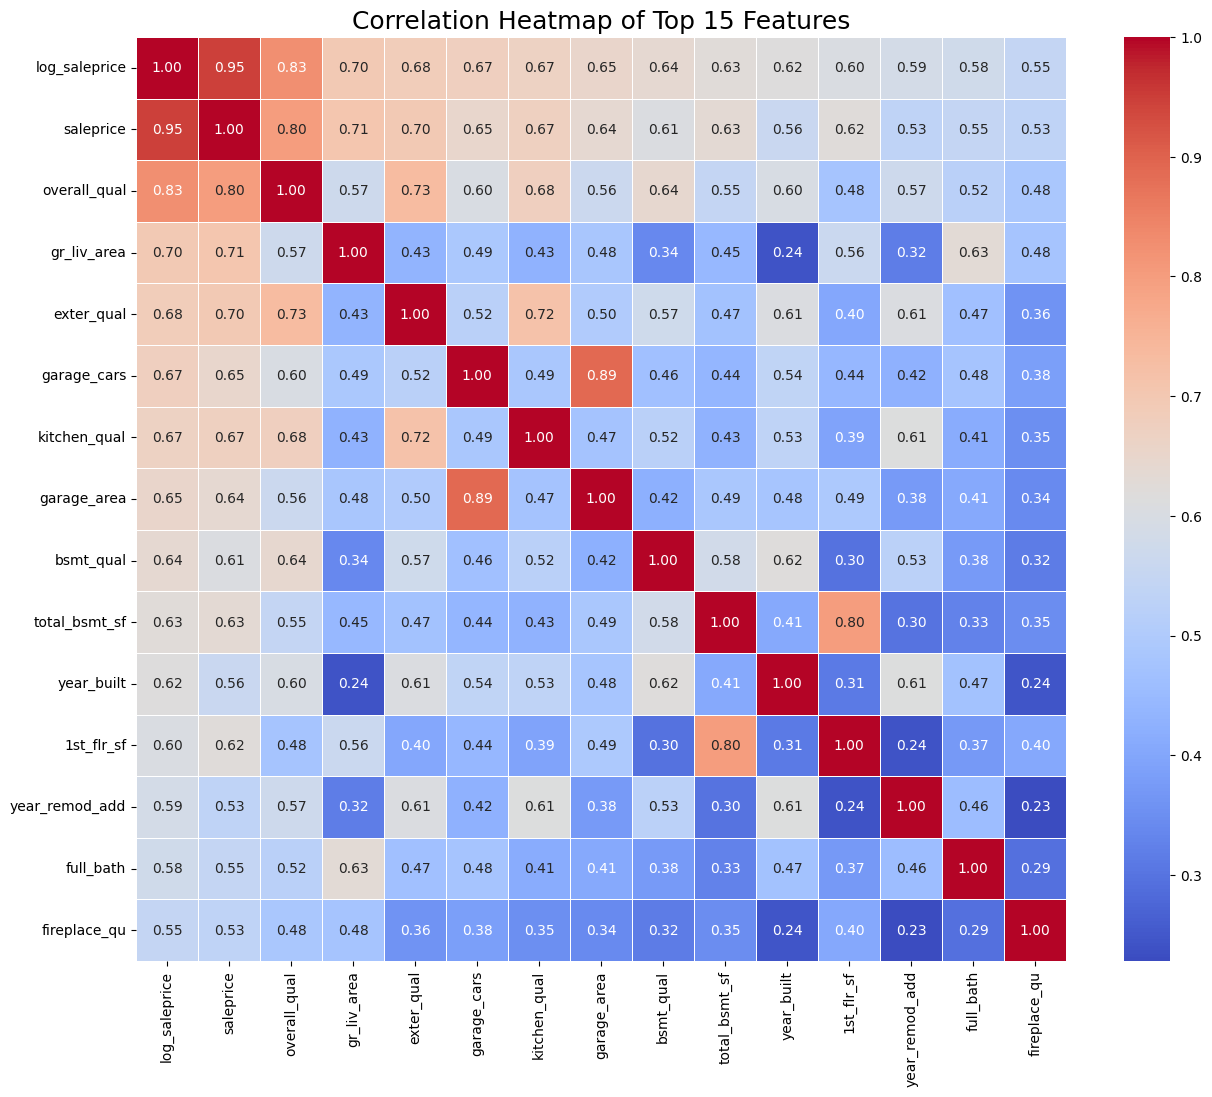

In [14]:
# --- 1. Calculate the Correlation Matrix ---
# First, select only the columns with numerical data types
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()


# --- 2. Find the Top N Features Correlated with SalePrice ---
# Get the correlations of all features with our LOG-TRANSFORMED target variable
saleprice_corr = correlation_matrix['log_saleprice'].sort_values(ascending=False)

# Select the top N features (including SalePrice itself)
N = 15
top_n_features = saleprice_corr.head(N).index

print(f"--- Top {N} Most Positively Correlated Features with log_saleprice ---")
print(saleprice_corr.head(N))


# --- 3. Create a Focused Heatmap of These Top Features ---
# Create a new correlation matrix containing only the top N features
top_n_corr_matrix = df[top_n_features].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(top_n_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title(f'Correlation Heatmap of Top {N} Features', fontsize=18)
plt.show()

**Observations from Correlation Analysis:**

*   **Key Drivers of Price:** The analysis clearly identifies the most influential numerical features. `overall_qual` has the strongest positive correlation with `log_saleprice` (r > 0.8), followed closely by `gr_liv_area` (living area square footage) and garage size (`garage_cars`, `garage_area`).
*   **Multicollinearity Identified:** The heatmap reveals strong correlations between some of the features themselves. For example, `garage_cars` and `garage_area` are highly correlated (r > 0.88), which is logical. Similarly, `gr_liv_area` and `totrms_abvgrd` (total rooms above ground) are also highly correlated. This is an important finding to note for future modeling, as including highly correlated features can be problematic for some models (like linear regression).

**Next Step:**
Now that we have our "shortlist" of the most important numerical features, our next step is to visualize their individual relationships with `saleprice` using scatter plots to check for linearity and other patterns.

### 3.4 Visualizing Key Numerical Relationships with Scatter Plots

The correlation heatmap gave us a quantitative measure of the linear relationships between features. Now, we will visualize these relationships using scatter plots. This will allow us to:

1.  Visually confirm the strength and direction of the relationships.
2.  Check for the **linearity assumption** required by linear regression.
3.  Identify any potential outliers or non-linear patterns.

We will create a grid of scatter plots for the top features we identified against our (log-transformed) `saleprice`.

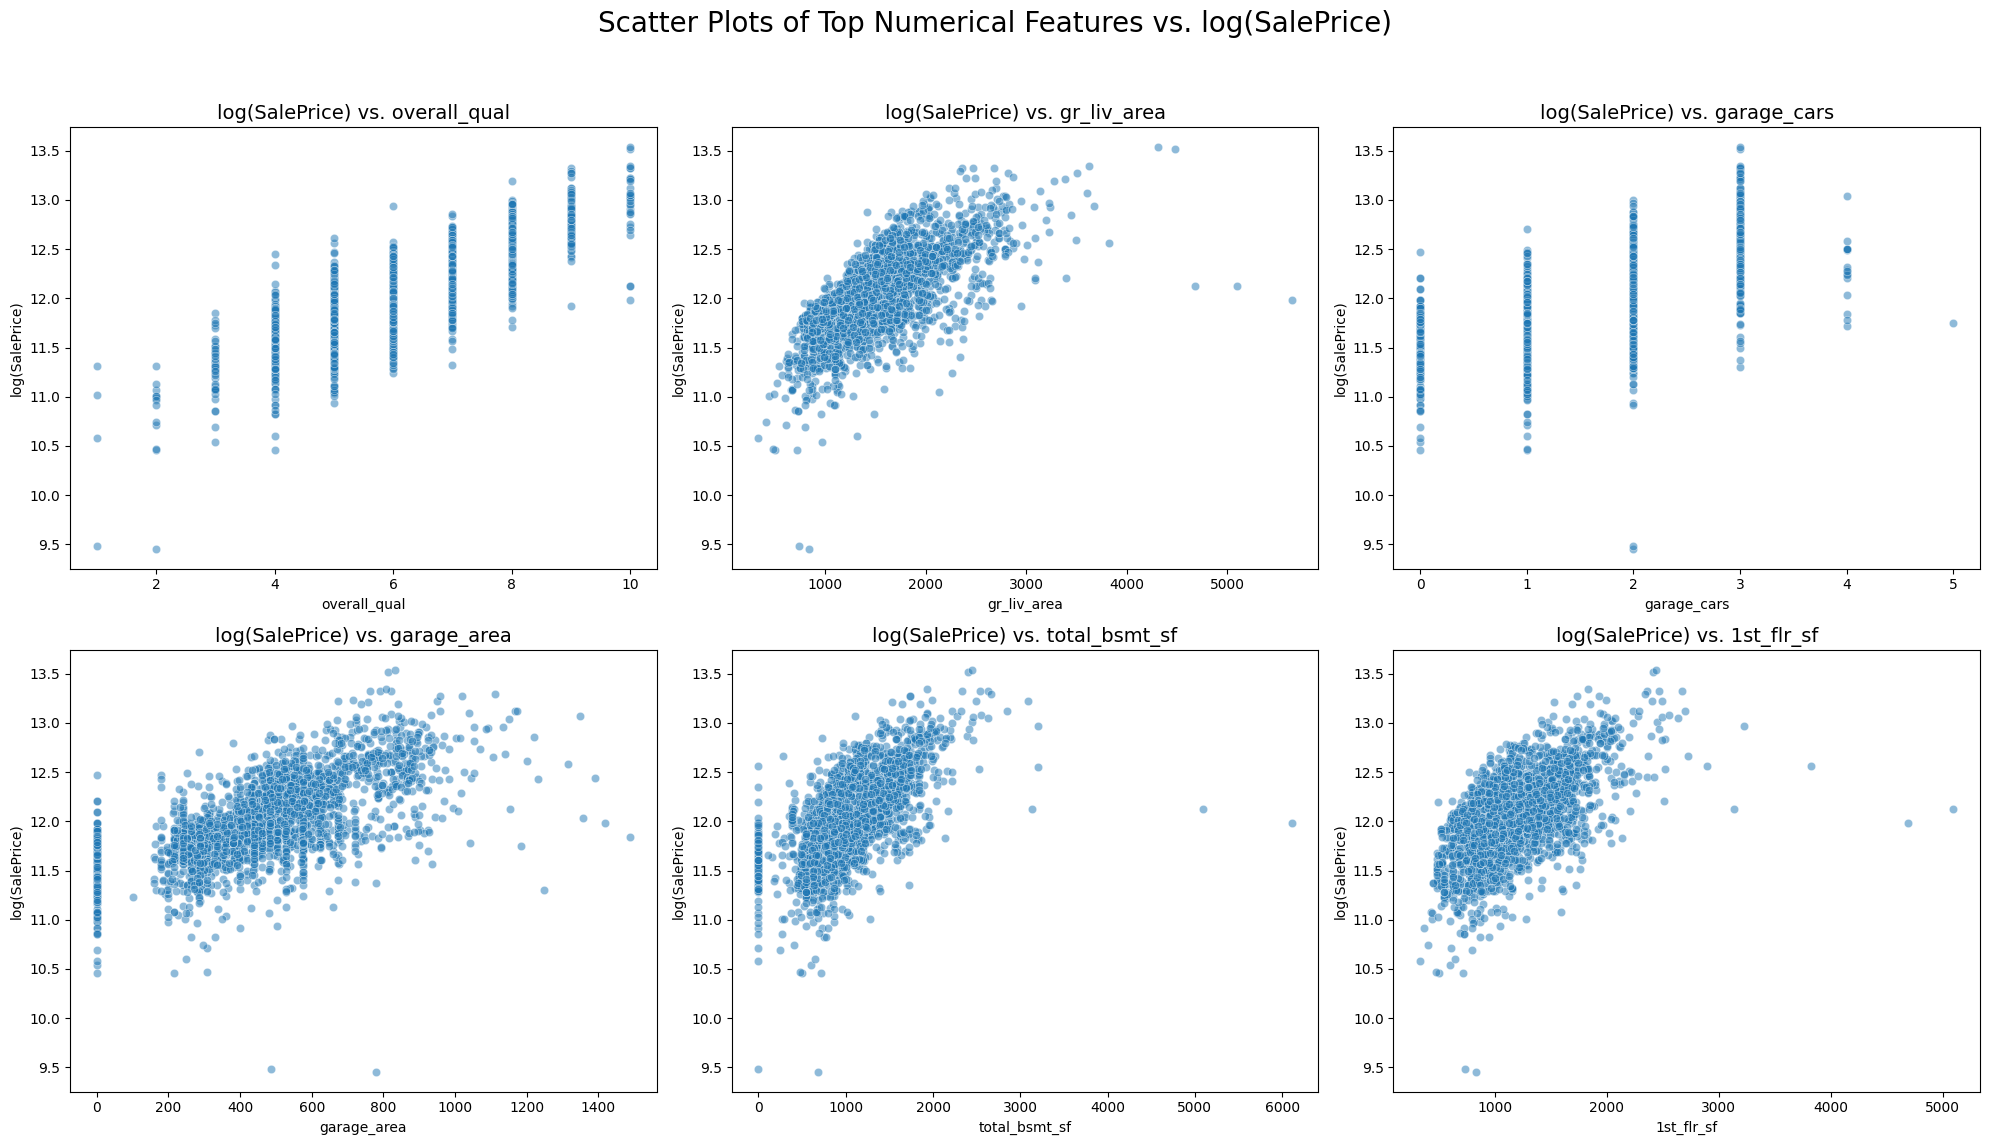

In [15]:
# --- Select the top features for plotting (excluding the target itself) ---
# We'll pick a few of the most interesting ones from our correlation list
# Let's choose the top 6 for a clean 2x3 grid.
features_to_plot = [
    'overall_qual', 'gr_liv_area', 'garage_cars',
    'garage_area', 'total_bsmt_sf', '1st_flr_sf'
]

# --- Create the grid of scatter plots ---
# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig.suptitle('Scatter Plots of Top Numerical Features vs. log(SalePrice)', fontsize=20)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the features and create a scatter plot for each
for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    # We use a scatter plot, but with some transparency (alpha) to see dense areas
    sns.scatterplot(x=df[feature], y=df['log_saleprice'], ax=ax, alpha=0.5)
    ax.set_title(f'log(SalePrice) vs. {feature}', fontsize=14)
    ax.set_xlabel(feature)
    ax.set_ylabel('log(SalePrice)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observations from the Scatter Plots:**

*   **Strong Linear Relationships Confirmed:** The plots for `gr_liv_area`, `garage_area`, `total_bsmt_sf`, and `1st_flr_sf` all show clear, strong positive linear relationships with `log_saleprice`. As these features increase, the sale price tends to increase in a predictable, linear fashion. This is excellent news for a linear model.
*   **`overall_qual` and `garage_cars`:** Since these are discrete numbers (you can't have 6.5 quality or 2.5 cars), they form distinct vertical lines. However, the trend is still clearly and powerfully linear—as the quality or number of cars increases, the median sale price increases significantly.
*   **Potential Outliers:** In the `gr_liv_area` plot, there are two data points at the far right (very large living area) that seem to have unusually low sale prices. These are classic outliers that could be investigated further or potentially removed before modeling, as they might unduly influence the regression line.
*   **Homoscedasticity Check:** For the most part, the "cloud" of points seems to have a relatively consistent vertical spread as we move from left to right. This suggests that the variance is fairly constant (homoscedastic), especially now that we've transformed the target variable. This is another positive sign for linear regression.

**Conclusion:**
Our most important numerical features exhibit strong linear relationships with the log-transformed `saleprice` and appear to satisfy the key assumptions for linear modeling.

### 3.5 Analyzing Key Categorical Features

Having thoroughly examined the numerical features, we now turn our attention to the categorical variables. Our goal is to identify which qualitative features have the most significant impact on `saleprice`.

We will use **box plots** to visualize the distribution of `log_saleprice` across the different groups within each categorical feature. This will allow us to quickly see which categories are associated with higher or lower house prices.

#### The Impact of `Neighborhood`
Location is often cited as the most important factor in real estate. Let's see how `saleprice` varies across different neighborhoods in Ames.

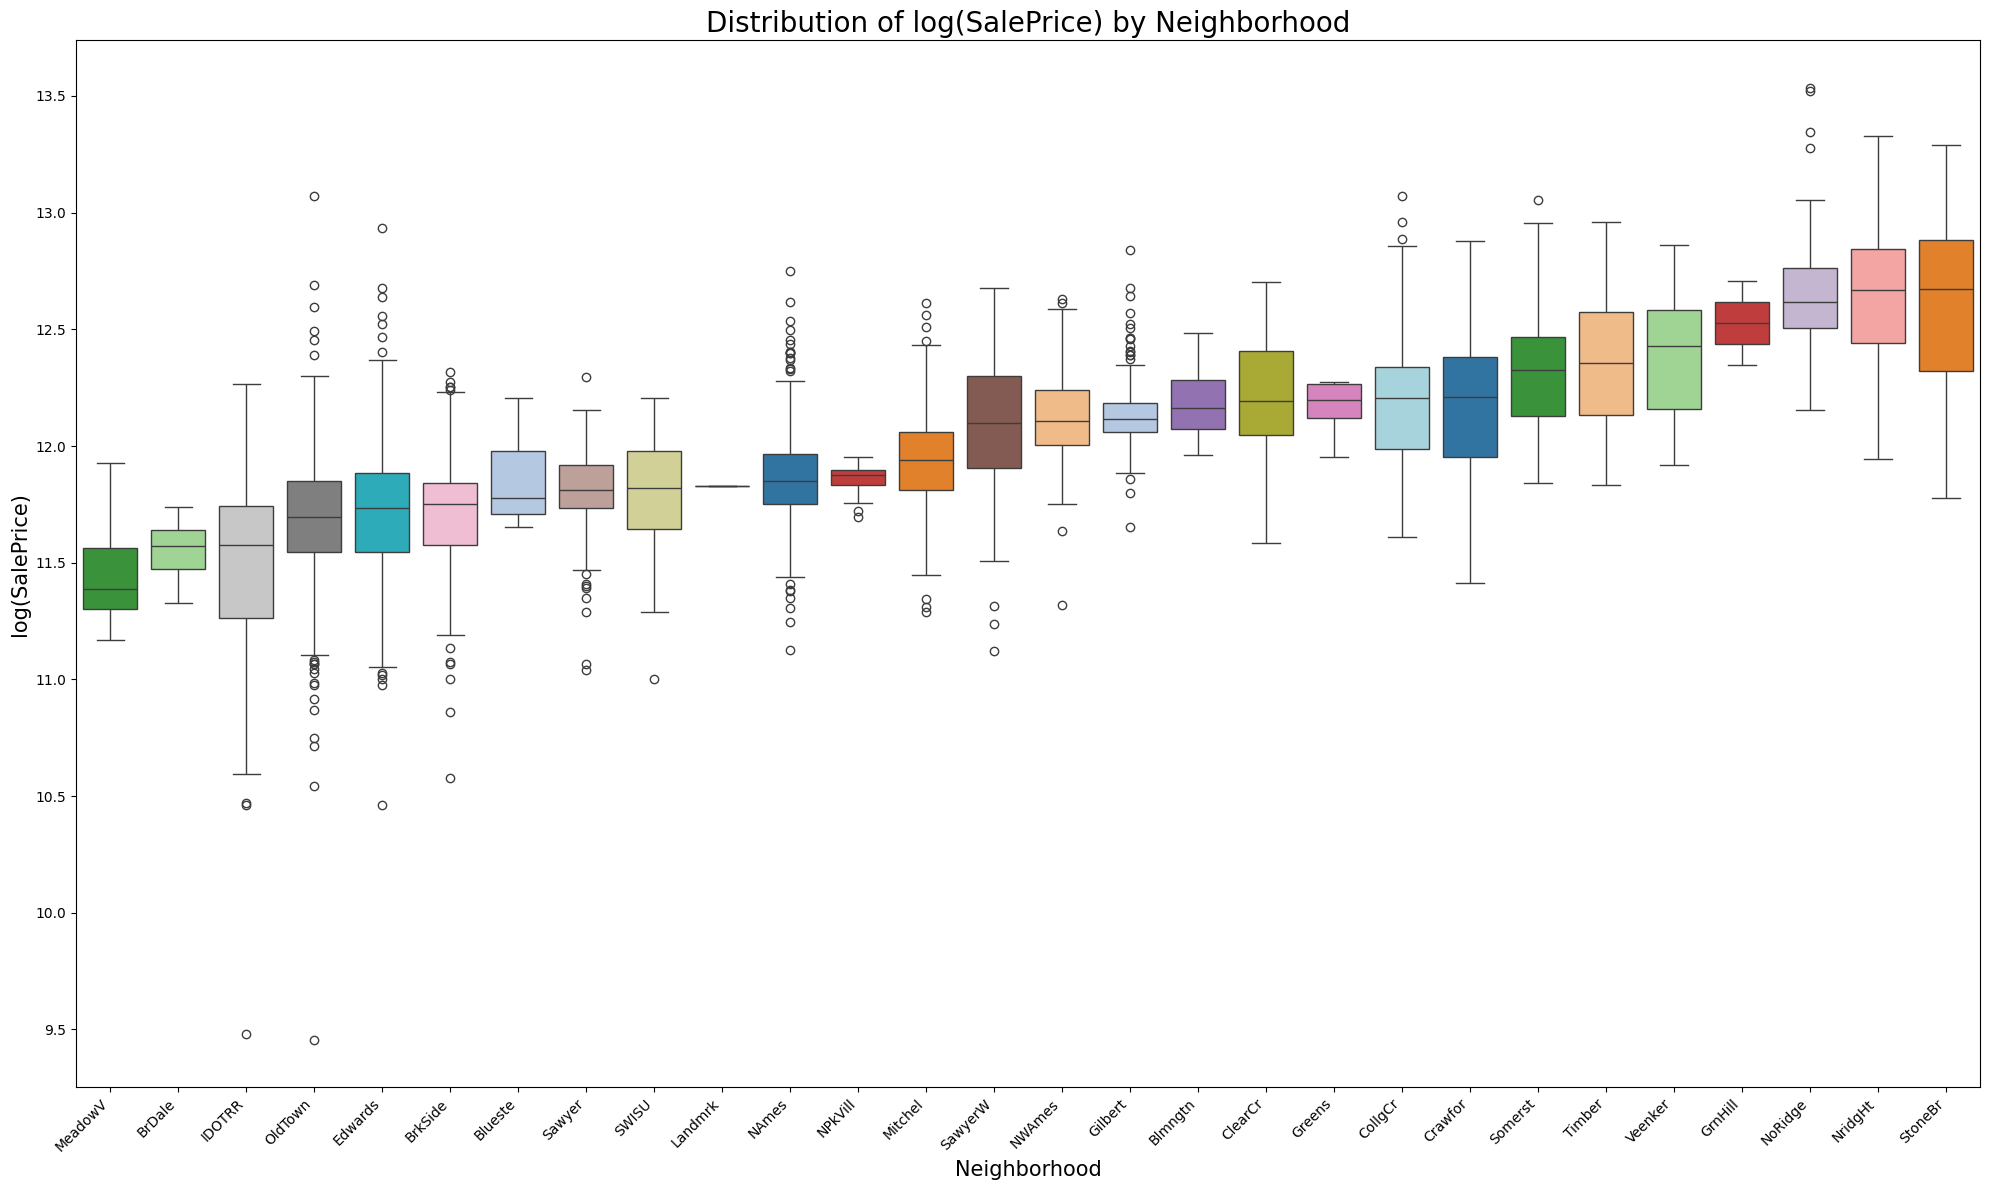

In [16]:
# --- Analyze log_saleprice by Neighborhood ---

# To make the plot readable, we should order the neighborhoods by their median sale price.
# 1. Calculate the median price for each neighborhood
median_prices = df.groupby('neighborhood')['saleprice'].median().sort_values()

# 2. Get the sorted order of neighborhood names
sorted_neighborhoods = median_prices.index


# --- Create the box plot ---
plt.figure(figsize=(20, 12))

# THE FIX: Assign x='neighborhood' to hue='neighborhood' and set legend=False
sns.boxplot(data=df, x='neighborhood', y='log_saleprice', order=sorted_neighborhoods,
            hue='neighborhood', legend=False, palette='tab20')

plt.title('Distribution of log(SalePrice) by Neighborhood', fontsize=20)
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('log(SalePrice)', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observations (Neighborhood):**

The box plot confirms that **location is a critical driver of house prices**.

*   **Clear Price Tiers:** There is a massive variance in median sale prices across different neighborhoods. We can clearly see distinct tiers of neighborhoods, from the most affordable (`MeadowV`, `IDOTRR`) to the most exclusive and expensive (`NoRidge`, `NridgHt`, `StoneBr`).
*   **Significance:** The separation between the boxes is very clear. The median price in a top-tier neighborhood can be more than double the median price in a bottom-tier one. This indicates that `neighborhood` is an extremely powerful predictive feature. For any modeling effort, this categorical variable would need to be properly encoded (e.g., one-hot encoding).

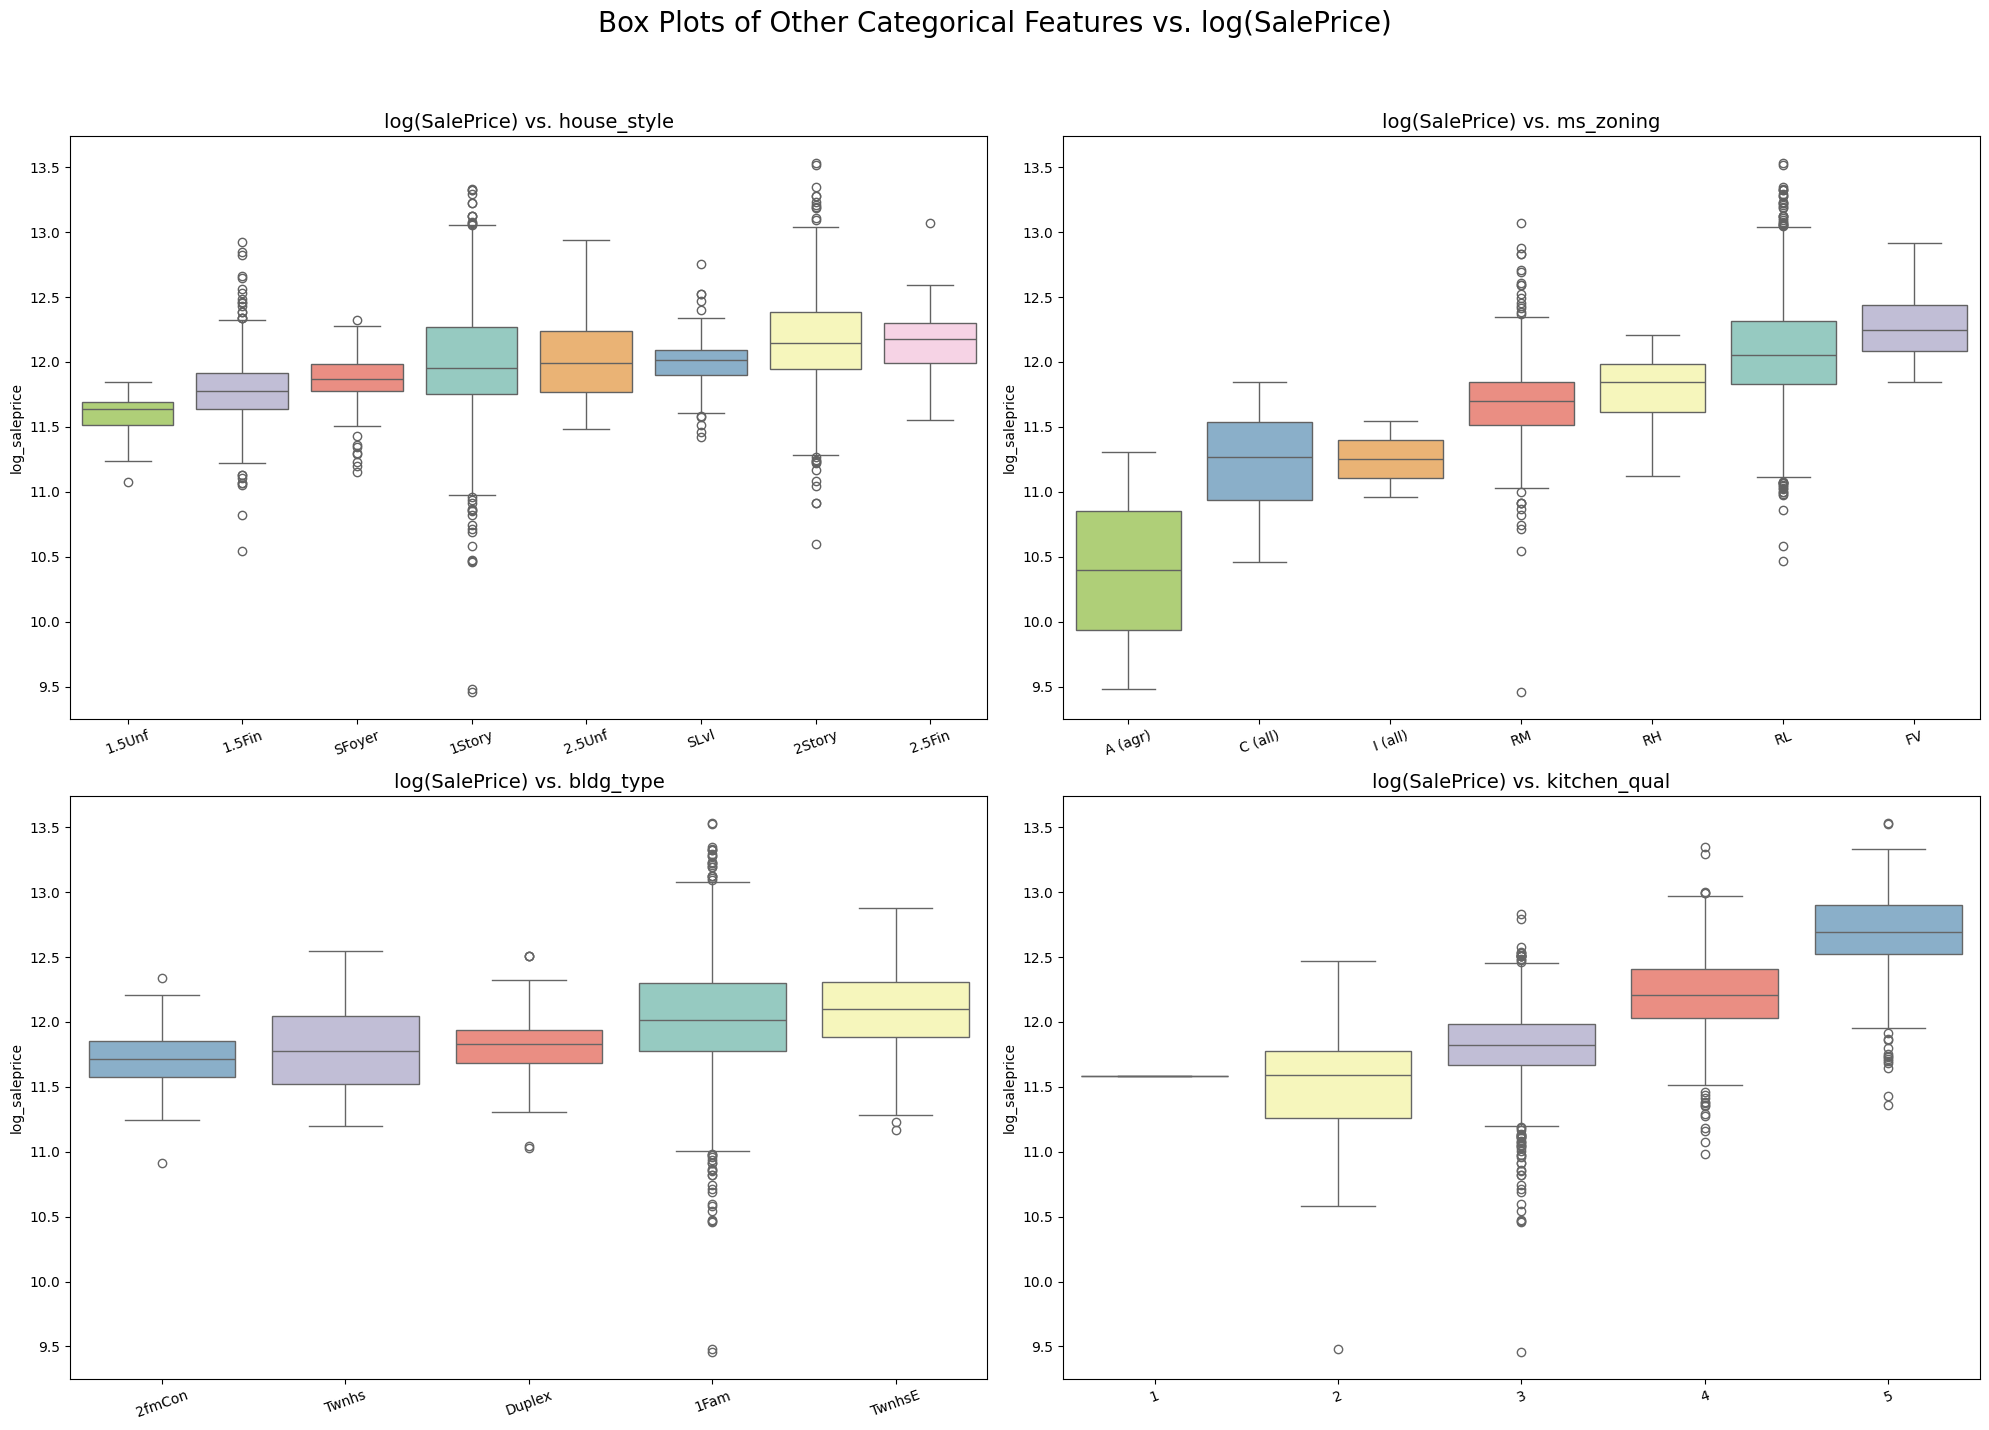

In [17]:
# --- Select a few other interesting categorical features ---
features_to_plot = [
    'house_style', 'ms_zoning', 'bldg_type', 'kitchen_qual'
]

# --- Create the grid of box plots ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.suptitle('Box Plots of Other Categorical Features vs. log(SalePrice)', fontsize=20)
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    # We sort by median price within each plot for clarity
    sorted_order = df.groupby(feature)['saleprice'].median().sort_values().index
    sns.boxplot(data=df, x=feature, y='log_saleprice', hue = feature, ax=ax, legend=False, order=sorted_order, palette='Set3')
    ax.set_title(f'log(SalePrice) vs. {feature}', fontsize=14)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observations from Other Categorical Features:**

The dashboard of other key categorical features provides further nuanced insights into the drivers of home value:

*   **`KitchenQual` (Kitchen Quality):** This feature shows a very strong, clear ordinal relationship with price. A house with an 'Excellent' (Ex) quality kitchen has a median `log_saleprice` that is significantly higher than one with a 'Good' (Gd) or 'Typical' (TA) kitchen. This confirms that kitchen quality is a major selling point and a reliable predictor of value.

*   **`MSZoning` (Zoning Classification):** The zoning of the property also has a distinct impact. 'Floating Village Residential' (FV) and 'Residential Low Density' (RL) zones are associated with the highest-priced homes, while commercial ('C (all)') zones are, as expected, at the lowest end.

*   **`HouseStyle`:** The style of the house shows a noticeable, but less dramatic, effect. Two-story houses (`2Story`) tend to have a higher median price than one-story (`1Story`) houses, which is logical as they often correspond to a larger `gr_liv_area`.

*   **`BldgType` (Type of Dwelling):** There is a clear difference here. 'Single-Family Detached' (`1Fam`) homes form the bulk of the market and have the highest median price. 'Townhouse End Unit' (`TwnhsE`) are next, while 'Duplex' and '2-Family Conversion' (`2fmCon`) properties are valued lower.

**Summary of Categorical Analysis:**
This confirms that beyond the all-important `Neighborhood`, other qualitative features like the quality of key rooms (`KitchenQual`), zoning, and the style/type of the dwelling are all significant secondary drivers of a home's final sale price.

## 4. Executive Summary & Key Drivers of Home Value

This in-depth Exploratory Data Analysis of the Ames Housing dataset was conducted with a statistical lens, aimed at identifying the most significant factors influencing `SalePrice` and preparing the groundwork for a robust regression model.

Our analysis, which included handling complex missing data, feature engineering, and testing for statistical assumptions like normality, has revealed a clear and compelling story about what determines a home's value in Ames, Iowa.

### The Profile of a High-Value Home:

Based on a comprehensive analysis of over 80 features, the highest-value properties consistently exhibit a combination of the following key characteristics:

1.  **Overall Quality (`OverallQual`):** This is, by a significant margin, the single most important feature. The material and finish quality of the house has a powerful, direct linear relationship with its sale price.
2.  **Size (`GrLivArea`):** The total above-ground living area is the second most crucial factor. Larger homes command exponentially higher prices.
3.  **Location (`Neighborhood`):** Location is paramount. There are clear, distinct tiers of neighborhoods, with homes in exclusive areas like 'Northridge', 'Stonebrook', and 'NridgHt' being valued significantly higher than those in more modest neighborhoods.
4.  **Garage Size (`GarageCars` & `GarageArea`):** The capacity and size of the garage are very strong predictors of price. A two or three-car garage is a major value-add.
5.  **Basement Size and Quality (`TotalBsmtSF` & `BsmtQual`):** A large, high-quality finished basement contributes substantially to a home's value.
6.  **Modernity (`YearBuilt` & `YearRemod/Add`):** Newer and recently remodeled homes are consistently valued higher than older homes, indicating a strong market preference for modern construction and amenities.

### Key Technical Findings for Modeling:

*   **Target Variable Transformation:** The `SalePrice` target variable was found to be severely right-skewed. A **log transformation** (`log(1+x)`) was successfully applied to normalize the distribution, making it suitable for linear regression modeling and improving model stability.
*   **Feature Relationships:** The key numerical drivers all exhibit strong, positive **linear relationships** with the log-transformed sale price.
*   **Multicollinearity:** Several top features contain redundant information (e.g., `GarageCars` and `GarageArea`). This was identified and would need to be handled in a linear regression model to ensure coefficient stability.

**Conclusion:**
This EDA has successfully identified and quantified the primary drivers of residential property value in Ames. The findings provide a robust, data-driven foundation for building an accurate predictive model. Any such model should be built using the log-transformed `SalePrice` and should prioritize features related to overall quality, size, location, and modernity.